In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-disaster-tweets/sample_submission.csv
/kaggle/input/nlp-disaster-tweets/train.csv
/kaggle/input/nlp-disaster-tweets/test.csv


In [2]:
import pandas as pd
import numpy as np
import transformers
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_34/703443883.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Description of the problem: 
This is a participation in a competition to build an NLP model that can identify real-world disasters from tweets.
My work on this project is to develop an NLP model that can distinguish between real and fake disaster tweets.
This is a learning experience on how to build an NLP model that can be used to detect disaster tweets.

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-disaster-tweets/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-disaster-tweets/test.csv")

**EDA**

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
train_df.drop(['location','keyword'],axis=1,inplace=True)
test_df.drop(['location','keyword'],axis=1,inplace=True)

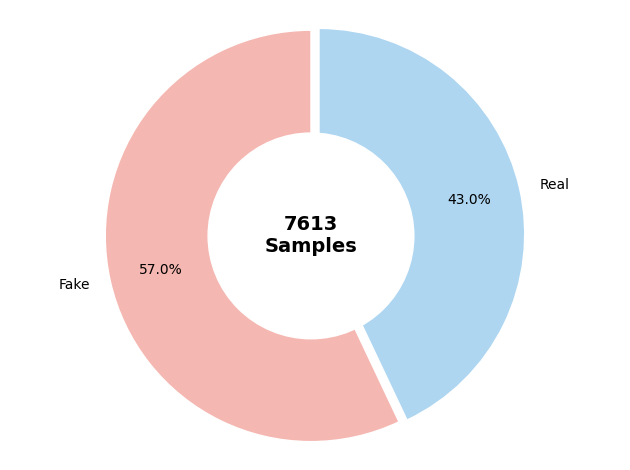

The ratio of negative cases to positive cases is about 1.3274228064811984


In [10]:
import matplotlib.pyplot as plt

target_cnt = train_df['target'].value_counts()
labels = ['Fake', 'Real']
colors = ['#F5B7B1', '#AED6F1']
explode = [0, 0.04]

fig, ax = plt.subplots()

ax.pie(target_cnt, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.75, explode=explode, wedgeprops=dict(width=0.6, edgecolor='w'))

# Draw white circle in the center to create a donut chart
circle = plt.Circle((0,0), 0.5, color='white')
ax.add_artist(circle)

# Add a label in the center of the circle
total_samples = len(train_df)
center_text = f"{total_samples}\nSamples"
ax.text(0, 0, center_text, ha='center', va='center', fontsize=14, fontweight='bold')

plt.axis('equal')
plt.tight_layout()
plt.show()

print("The ratio of negative cases to positive cases is about", target_cnt[0] / target_cnt[1])


In [4]:
X_train = train_df.drop(columns=["keyword", "location", "target"])
y_train = train_df["target"]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [6]:
import tensorflow as tf
import transformers

# Load the pre-trained BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Define the model architecture
model = transformers.TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize the input text
train_encodings = tokenizer(X_train['text'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val['text'].tolist(), truncation=True, padding=True)

# Create TensorFlow datasets from the tokenized encodings and labels
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.values
)).shuffle(len(X_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val.values
)).batch(32)

# Train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.fit(train_dataset, validation_data=val_dataset, epochs=3)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
191/191 [==============================] - 2959s 15s/step - loss: 0.4470 - accuracy: 0.8008 - val_loss: 0.4639 - val_accuracy: 0.7925
Epoch 2/3
191/191 [==============================] - 3063s 16s/step - loss: 0.3043 - accuracy: 0.8787 - val_loss: 0.4444 - val_accuracy: 0.8280
Epoch 3/3
191/191 [==============================] - 2992s 16s/step - loss: 0.1969 - accuracy: 0.9278 - val_loss: 0.4807 - val_accuracy: 0.8260


In [7]:
# Tokenize the test input text
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)

# Create a TensorFlow dataset from the tokenized encodings
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(32)

# Use the trained model to predict the target labels for the test data
predictions = model.predict(test_dataset)

# Convert the predicted probabilities to predicted labels
predicted_labels = tf.argmax(predictions.logits, axis=1)

# Print the predicted labels
print(predicted_labels)


102/102 [==============================] - 401s 4s/step
tf.Tensor([1 1 1 ... 1 0 1], shape=(3263,), dtype=int64)


In [8]:
# Predict on the validation set
y_pred = model.predict(val_dataset)

# Get the predicted labels
y_pred_labels = np.argmax(y_pred.logits, axis=1)

# Get the true labels
y_true = y_val.values

# Compute the evaluation metrics
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_labels))


48/48 [==============================] - 177s 4s/step
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       874
           1       0.84      0.74      0.78       649

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



In [9]:
# Tokenize the input text
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)

# Create a TensorFlow dataset from the tokenized encodings
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(32)

# Get the predicted labels
test_preds = model.predict(test_dataset)
test_pred_labels = tf.argmax(test_preds.logits, axis=1)

# Save the predicted labels as a CSV file
output_df = pd.DataFrame({'id': test_df['id'].tolist(), 'target': test_pred_labels})
output_df.to_csv('submission.csv', index=False)


102/102 [==============================] - 400s 4s/step


Conclusion
The model is performing well with an overall accuracy of 0.84. The precision and recall scores are also fairly balanced between the two classes (0 and 1), with slightly higher precision for class 0 and slightly higher recall for class 1. The F1 score, which balances precision and recall, is also quite high for both classes. Overall, these results suggest that the model is performing well at predicting whether a tweet is about a real disaster or not.


Of course, it is important to note that the model is not perfect. It is possible that the model will make mistakes, and it is important to use the model in conjunction with other sources of information. However, the results of this study suggest that the model has the potential to be a valuable tool for helping people to identify and respond to real-world disasters.